In [1]:
import pandas as pd

# Kastroulis, Angelo

This notebook contains the data cleanup and feature engineering. It takes the log files (the actual raw logs and screen scrapes that produced the logs were done with regex, etc.) and outputs 3 files:

- ``performance_data.csv`` (cleaned data with categorical features)
- ``performance_data_one_hot.csv`` (the categoricals are converted to one-hot encodings)
- ``performance_data_one_hot_augmented.csv`` (an augmented file with synthesized optimal values to balance the set. This data is not used, but included for reference)

There were 3 hardware systems on AWS EC2. For a full discussion see Background.ipynb.
- **M5D.2XLarge** (general purpose)
- **C5D.4XLarge** (compute optimized)
- **R5D.4XLarge** (memory optimized)

Information-only columns are added here and data is cleaned (not used in modeling):

| Field  | Description  |Type|
|---|---|---|
|info_query_id|The query id (1-16)|Info|
|info_batch|The batch and test run (ex. "3-2")|Info|
|info_ec2|The type of EC2 instance (e.g. "R5D4XLARGE")|Info|
|info_type|The type of Query|Info|
|s_opt|Did the optimizer choose this?|NOT USED|
|s_cost|What the optimizer computed as the cost of the query|NOT USED|
|s_rows|the rows the optmizer predicted|NOT USED|
|s_opt_sel|the selectivity computed by the optimizer|Info|
|s_opt_sel_cor|Is the optimizer's selectivity correct?|Info|
|s_forced_p|Was parallelism forced?|NOT USED|
|s_p_mode|Parallel Mode on?|NOT USED|
|s_p_cost|parallel_setup_cost setting|NOT USED|
|s_seq_page_cost|Cost hint for scanning a sequential page|NOT USED|
|s_random_page_cost|Cost hint for the random access penalty of a page access|NOT USED|
|s_cpu_tuple_cost|Cost hint for a scan tuple reconstruction|NOT USED|
|s_cpu_index_tuple_cost|Cost hint for index tuple reconstruction|NOT USED|
|s_cpu_operator_cost|Cost hint for a CPU operation|NOT USED|
|s_parallel_tuple_cost|Cost hint for tuple reconstruction|NOT USED|
|s_min_parallel_relation_size|Minimum to allow for parallel relations|NOT USED|
|s_effective_cache_size|The size of the effective cache in GB|NOT USED|

In [2]:
###### Load in the data 
#clean up all query column names. Some of them we missing the dash 
# in the name causing them to become numerical. We'll add that back in
def clean_batch_name(s):
    if "-" in s:
        return s 
    else:
        return s[0:1] + "-" + s[1:]

def clean_query(df):
    #set the values for each of the queries and rename
    df["info_query_id"] = df["query"]
    df["s_rows"] = df["rows"]
    df["s_cost"] = df["cost"]
    df["s_workers"] = df["workers"]
    df["s_forced_p"] = 0
    df["s_p_mode"] = df["parallel"]
    df["sc_o_q"] = df["o_q"]
    df["sc_o_p"] = df["o_p"]
    df["sc_o_s"] = df["o_s"]
    df["sc_o_e"] = df["o_e"]
    df["sc_o_d"] = df["o_d"]
    df["sc_q"] = df["s_q"]
    df["sc_p"] = df["s_p"]
    df["sc_s"] = df["s_s"]
    df["sc_e"] = df["s_e"]
    df["sc_d"] = df["s_d"]
    df["info_type"] = df["type"]
    #the 4's need dashes
    df["info_batch"] = df["batch"].astype(str).apply(lambda x: clean_batch_name(x))
    df = df.drop(["type","query","batch","rows", "cost","workers","forced_parallel","parallel","o_q","o_p","o_s","o_e","o_d","s_q","s_p","s_s","s_e","s_d"], axis=1)

    #set default values    
    df["s_p_cost"] = 1000 #set parallel_setup_cost = 1000; --default is 1000
    df["s_seq_page_cost"] = 1 #set seq_page_cost = 1; --1
    df["s_random_page_cost"] = 4 #set random_page_cost = 4; --4
    df["s_cpu_tuple_cost"] = .01 #set cpu_tuple_cost = .01; --.01
    df["s_cpu_index_tuple_cost"] = .005 #set cpu_index_tuple_cost = .005; --.005 this is for indexes only
    df["s_cpu_operator_cost"] = .0025 #set cpu_operator_cost = 0.0025; --.0025
    df["s_min_parallel_table_scan_size"] = 8 #set min_parallel_table_scan_size = '8MB'; --8 MB !!!!
    df["s_min_parallel_index_scan_size"] = .5 #set min_parallel_index_scan_size = '512kB'; --512 k   !!!!
    df["s_parallel_tuple_cost"] = .1 #default
    #df["s_min_parallel_relation_size"] = !!!!!
    
    df["s_effective_cache_size"] = 4 #set effective_cache_size = '4GB'; --4 GB
    
    df["idx_q"] = 0
    df["idx_e"] = 0
    df["idx_p"] = 0
    df["idx_s"] = 0
    df["idx_d"] = 0
    
    #Set all of the values forced by each of the queries
    #3-1 No indexes, parallel setup cost is 1000000
    df.loc[df['info_batch'] == "3-1", 's_p_cost'] = 1000000
    
    #3-2
    df.loc[df['info_batch'] == "3-2", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-2", 's_forced_p'] = 1
    
    
    #3-3
    #create index l_pk on lineitem using btree (l_partkey asc);
    df.loc[df['info_batch'] == "3-3", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-3", 'idx_p'] = 1
    
    #3-4
    df.loc[df['info_batch'] == "3-4", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-4", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-4", 'idx_p'] = 1
    
    #3-5
    #set parallel_setup_cost = 1000000; --default is 1000
    #create index l_sk on lineitem using btree (l_suppkey asc);
    df.loc[df['info_batch'] == "3-5", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-5", 'idx_s'] = 1
    
    #3-6
    #set parallel_setup_cost = 1000000; --default is 1000
    #create index l_sk on lineitem using btree (l_suppkey asc);
    df.loc[df['info_batch'] == "3-6", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-6", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-6", 'idx_s'] = 1
    
    #3-6a
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-6a", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-6a", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-6a", 'idx_d'] = 1
    
    #3-6b
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-6b", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-6b", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-6b", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-6b", 'idx_d'] = 1
    
    #3-6c
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-6c", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-6c", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-6c", 'idx_d'] = 1
    df.loc[df['info_batch'] == "3-6c", 'idx_q'] = 1

    #3-7
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-7", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-7", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-7", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-7", 'idx_d'] = 1
    df.loc[df['info_batch'] == "3-7", 'idx_q'] = 1
    
    #3-8
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-8", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-8", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-8", 'idx_q'] = 1
    
    #3-9
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-9", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-9", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-9", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-9", 'idx_q'] = 1
    
    #3-10
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-10", 's_p_cost'] = 1000000
    #df.loc[df['info_batch'] == "3-10", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-10", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-10", 'idx_q'] = 1
    
    #3-10a
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-10a", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-10a", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-10a", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-10a", 'idx_q'] = 1
    
    #3-11
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-11", 's_p_cost'] = 1000000
    #df.loc[df['info_batch'] == "3-11", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-11", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-11", 'idx_p'] = 1
    
    
    #3-12
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost =  1000
    df.loc[df['info_batch'] == "3-12", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-12", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-12", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-12", 'idx_p'] = 1
    
    #3-14
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-14", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-14", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-14", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-14", 'idx_s'] = 1

    #3-15
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-15", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-15", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-15", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-15", 'idx_s'] = 1
    
    #3-15a
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-15a", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-15a", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-15a", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-15a", 'idx_s'] = 1

    #3-16
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-16", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-16", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-16", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-16", 'idx_s'] = 1
    
    #3-17
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-17", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-17", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-17", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-17", 'idx_s'] = 1    
    df.loc[df['info_batch'] == "3-17", 'idx_e'] = 1    
    
    #3-18
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-18", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-18", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-18", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-18", 'idx_s'] = 1    
    df.loc[df['info_batch'] == "3-18", 'idx_e'] = 1  
    
    #3-19
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-19", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-19", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-19", 'idx_p'] = 1  
    
    #3-20
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-20", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-20", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-20", 'idx_p'] = 1 
    
    
     #3-21
    #create index l_sk on lineitem using btree;
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-21", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-21", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-21", 'idx_s'] = 1  
    
    #3-22
    #create index l_sk on lineitem using btree 
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-22", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-22", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-22", 'idx_s'] = 1    
    
    #3-23
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-23", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-23", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-23", 'idx_s'] = 1  
    df.loc[df['info_batch'] == "3-23", 'idx_d'] = 1  
    
    #3-24
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-24", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-24", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-24", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-24", 'idx_d'] = 1  
    
    
    #3-25
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-25", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-25", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-25", 'idx_s'] = 1  
    df.loc[df['info_batch'] == "3-25", 'idx_d'] = 1  
    df.loc[df['info_batch'] == "3-25", 'idx_q'] = 1 
    
    #3-26
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = ON; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "3-26", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-26", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-26", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-26", 'idx_d'] = 1  
    df.loc[df['info_batch'] == "3-26", 'idx_q'] = 1 
    
    
    #3-27
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-27", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-27", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-27", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-27", 'idx_q'] = 1
    
    #3-28
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-28", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-28", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-28", 'idx_s'] = 1
    df.loc[df['info_batch'] == "3-28", 'idx_q'] = 1    
    
    #3-29
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-29", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-29", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-29", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-29", 'idx_q'] = 1
    
    #3-30
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-30", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-30", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-30", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-30", 'idx_q'] = 1    
    
    #3-31
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-31", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-31", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-31", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-31", 'idx_q'] = 1
    df.loc[df['info_batch'] == "3-31", 'idx_p'] = 1 
    
    #3-32
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-32", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-32", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-32", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-32", 'idx_q'] = 1       
    df.loc[df['info_batch'] == "3-32", 'idx_p'] = 1     

    #3-33
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-33", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-33", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-33", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-33", 'idx_s'] = 1
    
    #3-34
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-34", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-34", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-34", 'idx_e'] = 1
    df.loc[df['info_batch'] == "3-34", 'idx_s'] = 1       
    
    #3-35
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-35", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-35", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-35", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-35", 'idx_s'] = 1
    
    #3-36
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-36", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-36", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-36", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-36", 'idx_s'] = 1    
    
    #3-37. This might be an error, but it's exactly the same as 35
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-37", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "3-37", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "3-37", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-37", 'idx_s'] = 1

    #3-38 (same as 36)
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "3-38", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "3-38", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "3-38", 'idx_p'] = 1
    df.loc[df['info_batch'] == "3-38", 'idx_s'] = 1   
    
    #4-1 allow bitmapscan
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "4-1", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "4-1", 's_forced_p'] = 1
    df.loc[df['info_batch'] == "4-1", 'idx_p'] = 1
    df.loc[df['info_batch'] == "4-1", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "4-1", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "4-1", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "4-1", 'idx_d'] = 1 
    
    #4-2 no bitmapscan
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000; --default is 1000
    df.loc[df['info_batch'] == "4-2", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "4-2", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "4-2", 'idx_p'] = 1
    df.loc[df['info_batch'] == "4-2", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "4-2", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "4-2", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "4-2", 'idx_d'] = 1     
    
    #4-3 no bitmapscan
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "4-3", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "4-3", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "4-3", 'idx_p'] = 1
    df.loc[df['info_batch'] == "4-3", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "4-3", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "4-3", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "4-3", 'idx_d'] = 1  

    #4-4 allow bitmapscan
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "4-4", 's_p_cost'] = 1000000
    df.loc[df['info_batch'] == "4-4", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "4-4", 'idx_p'] = 1
    df.loc[df['info_batch'] == "4-4", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "4-4", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "4-4", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "4-4", 'idx_d'] = 1 
    
    #4-5 allow bitmapscan
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set force_parallel_mode = OFF; --turn off workers
    #set parallel_setup_cost = 1000000; --default is 1000
    df.loc[df['info_batch'] == "4-5", 's_p_cost'] = 1000
    df.loc[df['info_batch'] == "4-5", 's_forced_p'] = 0
    df.loc[df['info_batch'] == "4-5", 'idx_p'] = 1
    df.loc[df['info_batch'] == "4-5", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "4-5", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "4-5", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "4-5", 'idx_d'] = 1 
    
    #2-1 no bitmapscan, indexes off...
    #create index l_qty on lineitem using btree (l_quantity asc);
    #create index l_dis on lineitem using btree (l_discount asc);
    #create index l_sk on lineitem using btree (l_suppkey asc);
    #create index l_ep on lineitem using btree (l_extendedprice desc);
    #create index l_pk on lineitem using btree (l_partkey desc);
    #set seq_page_cost = 2; --1
    df.loc[df['info_batch'] == "2-1", 's_seq_page_cost'] = 2
    df.loc[df['info_batch'] == "2-2", 's_seq_page_cost'] = 3
    df.loc[df['info_batch'] == "2-3", 's_seq_page_cost'] = 4
    df.loc[df['info_batch'] == "2-4", 's_seq_page_cost'] = 5
    df.loc[df['info_batch'] == "2-5", 's_random_page_cost'] = 1
    df.loc[df['info_batch'] == "2-6", 's_random_page_cost'] = 2
    df.loc[df['info_batch'] == "2-7", 's_random_page_cost'] = 3
    df.loc[df['info_batch'] == "2-8", 's_random_page_cost'] = 5
    df.loc[df['info_batch'] == "2-9", 's_cpu_tuple_cost'] = .02
    df.loc[df['info_batch'] == "2-10", 's_cpu_tuple_cost'] = .03
    df.loc[df['info_batch'] == "2-11", 's_cpu_tuple_cost'] = .04
    df.loc[df['info_batch'] == "2-12", 's_cpu_tuple_cost'] = .05
    df.loc[df['info_batch'] == "2-13", 's_cpu_operator_cost'] = 0.0035
    df.loc[df['info_batch'] == "2-14", 's_cpu_operator_cost'] = 0.0015
    df.loc[df['info_batch'] == "2-15", 's_cpu_operator_cost'] = 0.0005
    df.loc[df['info_batch'] == "2-16", 's_cpu_operator_cost'] = 0.0055
    df.loc[df['info_batch'] == "2-17", 's_p_cost'] = 2000
    df.loc[df['info_batch'] == "2-18", 's_p_cost'] = 10
    df.loc[df['info_batch'] == "2-19", 's_p_cost'] = 100
    df.loc[df['info_batch'] == "2-20", 's_p_cost'] = 5000
    df.loc[df['info_batch'] == "2-21", 's_p_cost'] = 8000
    df.loc[df['info_batch'] == "2-22", 's_p_cost'] = 10000
    df.loc[df['info_batch'] == "2-23", 's_parallel_tuple_cost'] = .01
    df.loc[df['info_batch'] == "2-24", 's_parallel_tuple_cost'] = .001
    df.loc[df['info_batch'] == "2-26", 's_parallel_tuple_cost'] = .5
    df.loc[df['info_batch'] == "2-27", 's_parallel_tuple_cost'] = .2
    #all indexes on
    df.loc[df['info_batch'] == "2-28", 's_effective_cache_size'] = 1
    df.loc[df['info_batch'] == "2-28", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-28", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-28", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-28", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-28", 'idx_d'] = 1 

    df.loc[df['info_batch'] == "2-29", 's_effective_cache_size'] = 2
    df.loc[df['info_batch'] == "2-29", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-29", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-29", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-29", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-29", 'idx_d'] = 1 
    
    df.loc[df['info_batch'] == "2-30", 's_effective_cache_size'] = 8
    df.loc[df['info_batch'] == "2-30", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-30", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-30", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-30", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-30", 'idx_d'] = 1 
    
    df.loc[df['info_batch'] == "2-31", 's_effective_cache_size'] = 16
    df.loc[df['info_batch'] == "2-31", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-31", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-31", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-31", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-31", 'idx_d'] = 1 
    
    df.loc[df['info_batch'] == "2-32", 's_min_parallel_table_scan_size'] = 1
    df.loc[df['info_batch'] == "2-32", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-32", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_d'] = 1     
    
    df.loc[df['info_batch'] == "2-33", 's_min_parallel_table_scan_size'] = 4
    df.loc[df['info_batch'] == "2-33", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-33", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-33", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-33", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-33", 'idx_d'] = 1     
    
    df.loc[df['info_batch'] == "2-34", 's_min_parallel_table_scan_size'] = 16
    df.loc[df['info_batch'] == "2-34", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-34", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-34", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-34", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-34", 'idx_d'] = 1 
    
    df.loc[df['info_batch'] == "2-32", 's_min_parallel_table_scan_size'] = 1
    df.loc[df['info_batch'] == "2-32", 'idx_p'] = 1
    df.loc[df['info_batch'] == "2-32", 'idx_s'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_e'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_q'] = 1 
    df.loc[df['info_batch'] == "2-32", 'idx_d'] = 1     
    
    return df

The hardware features are:

| Field  | Description  |Type|
|---|---|---|
|h_mem|System Memory (GB)|Continuous|
|h_cpu|CPU Architecture Name|Categorical|
|h_cores|Number of CPU Cores|Continuous|
|h_clk|CPU Clock Speed (Mhz)|Continuous|
|h_l1d|Level 1 Cache for data|Continuous|
|h_l1i|Level 1 Cache for instructions|Continuous|
|h_l2|Level 2 Cache|Continuous|
|h_l3|Level 3 Cache|Continuous|
|h_numa|Numa Aware?|Categorical|
|h_avx2|Supports SIMD?|Categorical|
|h_avx512bw|Support SIMD 512 Byte Words?|Categorical|
|h_avx512vl|Support SIMD 512 Byte Words?|Categorical|
|h_avx512cd|Support SIMD 512 Conflict Detection?|Categorical|
|h_avx512dq|Support SIMD 512 Double and Quad Words?|Categorical|

In [3]:
#This sets the variables defining each of the systems
def set_hardware(df):
    df["h_mem"] = 0 #in GB
    df["h_cores"] = 0
    df["info_cpu"] = "Intel(R) Xeon(R)"
    df["h_clk"] = 0.0
    df["h_l1d"] = 0 #in kb
    df["h_l1i"] = 0 #kb
    df["h_l2"] = 0 #k
    df["h_l3"] = 0 #k
    df["h_numa"] = 1
    df["h_avx2"] = 1
    df["h_avx512bw"] = 1
    df["h_avx512vl"] = 1
    df["h_avx512cd"] = 1
    df["h_avx512dq"] = 0
    df["h_bogomips"] = 0.0
    df["h_ss"] = 0 #CPU cache implements self-snoop
    df["h_3dnowprefetch"] = 0
    df["h_erms"] = 0
    df["h_bmi2"] = 0 #bit manipulation
    df["h_invpcid"] = 0
        
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_mem'] = 128
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_cores'] = 16
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'info_cpu'] = "Intel(R) Xeon(R) Platinum 8175M"
    df.loc[df['info_ec2'] == "r5d.4xlarge", "h_clk"] = 3110.95
    df.loc[df['info_ec2'] == "r5d.4xlarge", "h_l1d"] = 32 #in 
    df.loc[df['info_ec2'] == "r5d.4xlarge", "h_l1i"] = 32 #kb
    df.loc[df['info_ec2'] == "r5d.4xlarge", "h_l2"] = 1024 #k
    df.loc[df['info_ec2'] == "r5d.4xlarge", "h_l3"] = 33792 #k
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_avx512dq'] = 1
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_bogomips'] = 5000.0
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_ss'] = 1
    df.loc[df['info_ec2'] == "r5d.4xlarge", 'h_3dnowprefetch'] = 1
    
    
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_mem'] = 30
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_cores'] = 16
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'info_cpu'] = "Intel(R) Xeon(R) Platinum 8124M"
    df.loc[df['info_ec2'] == "c5d.4xlarge", "h_clk"] = 3405.776
    df.loc[df['info_ec2'] == "c5d.4xlarge", "h_l1d"] = 32 #in 
    df.loc[df['info_ec2'] == "c5d.4xlarge", "h_l1i"] = 32 #kb
    df.loc[df['info_ec2'] == "c5d.4xlarge", "h_l2"] = 1024 #k
    df.loc[df['info_ec2'] == "c5d.4xlarge", "h_l3"] = 25344 #k
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_avx512dq'] = 1
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_bogomips'] = 6000.0
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_ss'] = 1
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_3dnowprefetch'] = 1
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_bmi2'] = 1
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_erms'] = 1
    df.loc[df['info_ec2'] == "c5d.4xlarge", 'h_invpcid'] = 1  

    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_mem'] = 32
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_cores'] = 16
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'info_cpu'] = "Intel(R) Xeon(R) CPU E5-2686 v4"
    df.loc[df['info_ec2'] == "m5d.2xlarge", "h_clk"] = 2300.107
    df.loc[df['info_ec2'] == "m5d.2xlarge", "h_l1d"] = 32 #in 
    df.loc[df['info_ec2'] == "m5d.2xlarge", "h_l1i"] = 32 #kb
    df.loc[df['info_ec2'] == "m5d.2xlarge", "h_l2"] = 256 #k
    df.loc[df['info_ec2'] == "m5d.2xlarge", "h_l3"] = 46080 #k
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_bogomips'] = 4600.08
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_bmi2'] = 1
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_erms'] = 1
    df.loc[df['info_ec2'] == "m5d.2xlarge", 'h_invpcid'] = 1
        
    return df
    

The data files are then combined (adding hardware features) and cleaned (column data types, etc.).

In [4]:
df_c5_t5 = pd.read_csv('data/c5d4xlarge-test5.txt')
df_m5_t5 = pd.read_csv('data/m5d2xlarge-test5.txt')
df_r5_t5 = pd.read_csv('data/r5d4xlarge-test5.txt')
df_c5_t4 = pd.read_csv('data/c5d4xlarge-test4.txt')
df_m5_t4 = pd.read_csv('data/m5d2xlarge-test4.txt', index_col=0)
df_r5_t4 = pd.read_csv('data/r5d4xlarge-test4.txt')
df_c5_t3 = pd.read_csv('data/c5d4xlarge-test3.txt')
df_m5_t3 = pd.read_csv('data/m5d2xlarge-test3.txt')
df_r5_t3 = pd.read_csv('data/r5d4xlarge-test3.txt')
df_c5_t2 = pd.read_csv('data/c5d4xlarge-test2.txt')
df_m5_t2 = pd.read_csv('data/m5d2xlarge-test2.txt')
df_r5_t2 = pd.read_csv('data/r5d4xlarge-test2.txt')

In [5]:
df_c5_t5.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency'],
      dtype='object')

In [6]:
df_m5_t4.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'query', 'batch',
       'selectivity', 'latency'],
      dtype='object')

In [7]:
df_m5_t4["forced_parallel"] = 0

In [8]:
df_m5_t4 = df_m5_t4[['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel','query', 'batch', 'selectivity', 'latency']]

In [9]:
df_m5_t5.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency'],
      dtype='object')

In [16]:
df_m5_t5.dtypes == df_m5_t4.dtypes

workers            True
cost               True
rows               True
type               True
parallel           True
i_q                True
i_p                True
i_s                True
i_e                True
i_d                True
i_o_q              True
i_o_p              True
i_o_s              True
i_o_e              True
i_o_d              True
b_i_q              True
b_i_p              True
b_i_s              True
b_i_e              True
b_i_d              True
s_q                True
s_p                True
s_s                True
s_e                True
s_d                True
o_q                True
o_p                True
o_s                True
o_e                True
o_d                True
v_i_q              True
v_i_p              True
v_i_s              True
v_i_e              True
v_i_d              True
v_f_q              True
v_f_p              True
v_f_s              True
v_f_e              True
v_f_d              True
forced_parallel    True
query           

In [13]:
df_c5_t4.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency'],
      dtype='object')

In [14]:
df_c5_t4["batch"] = df_c5_t4["batch"].astype(str)
df_m5_t4["batch"] = df_m5_t4["batch"].astype(str)
df_r5_t4["batch"] = df_r5_t4["batch"].astype(str)

In [15]:
df_c5_t5["v_i_d"] = df_c5_t5["v_i_d"].astype(float)
df_m5_t5["v_i_d"] = df_m5_t5["v_i_d"].astype(float)
df_r5_t5["v_i_d"] = df_r5_t5["v_i_d"].astype(float)
df_c5_t2["v_i_d"] = df_c5_t2["v_i_d"].astype(float)
df_m5_t2["v_i_d"] = df_m5_t2["v_i_d"].astype(float)
df_r5_t2["v_i_d"] = df_r5_t2["v_i_d"].astype(float)
df_c5_t5["v_f_d"] = df_c5_t5["v_f_d"].astype(float)
df_m5_t5["v_f_d"] = df_m5_t5["v_f_d"].astype(float)
df_r5_t5["v_f_d"] = df_r5_t5["v_f_d"].astype(float)
df_c5_t2["v_f_d"] = df_c5_t2["v_f_d"].astype(float)
df_m5_t2["v_f_d"] = df_m5_t2["v_f_d"].astype(float)
df_r5_t2["v_f_d"] = df_r5_t2["v_f_d"].astype(float)

In [17]:
df_c5_t3.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency'],
      dtype='object')

In [18]:
df_c5_t2.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'parllelmode', 'parallelsetupcost', 'seq_page_cost',
       'random_page_cost', 'cpu_tuple_cost', 'cpu_index_tuple_cost',
       'cpu_operator_cost', 'parallel_tuple_cost',
       'min_parallel_relation_size', 'effective_cache_size', 'selectivity',
       'latency'],
      dtype='object')

Drop unnecessary old column names. 

In [19]:
df_c5_t2 = df_c5_t2.drop(['parllelmode', 'parallelsetupcost', 'seq_page_cost',
       'random_page_cost', 'cpu_tuple_cost', 'cpu_index_tuple_cost',
       'cpu_operator_cost', 'parallel_tuple_cost',
       'min_parallel_relation_size', 'effective_cache_size'], axis=1)

In [20]:
df_m5_t2 = df_m5_t2.drop(['parllelmode', 'parallelsetupcost', 'seq_page_cost',
       'random_page_cost', 'cpu_tuple_cost', 'cpu_index_tuple_cost',
       'cpu_operator_cost', 'parallel_tuple_cost',
       'min_parallel_relation_size', 'effective_cache_size'], axis=1)
df_r5_t2 = df_r5_t2.drop(['parllelmode', 'parallelsetupcost', 'seq_page_cost',
       'random_page_cost', 'cpu_tuple_cost', 'cpu_index_tuple_cost',
       'cpu_operator_cost', 'parallel_tuple_cost',
       'min_parallel_relation_size', 'effective_cache_size'], axis=1)

In [21]:
# Add an informational column that tells us which server the row came from
# and combine them all
df_c5_t5["info_ec2"] = "c5d.4xlarge"
df_c5_t4["info_ec2"] = "c5d.4xlarge"
df_c5_t3["info_ec2"] = "c5d.4xlarge"
df_c5_t2["info_ec2"] = "c5d.4xlarge"

df_m5_t5["info_ec2"] = "m5d.2xlarge"
df_m5_t4["info_ec2"] = "m5d.2xlarge"
df_m5_t3["info_ec2"] = "m5d.2xlarge"
df_m5_t2["info_ec2"] = "m5d.2xlarge"

df_r5_t5["info_ec2"] = "r5d.4xlarge"
df_r5_t4["info_ec2"] = "r5d.4xlarge"
df_r5_t3["info_ec2"] = "r5d.4xlarge"
df_r5_t2["info_ec2"] = "r5d.4xlarge"

df = pd.concat([df_c5_t5, df_m5_t5, df_r5_t5, df_c5_t4, df_m5_t4, df_r5_t4, df_c5_t3, df_m5_t3, df_r5_t3, df_c5_t2, df_m5_t2, df_r5_t2])



In [22]:
df.shape

(25329, 46)

In [23]:
# now clean
df = clean_query(df)
df.head()

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,...,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d
0,0,0,0,0,0,0,0,0,0,0,...,0.0025,8,0.5,0.1,4,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0025,8,0.5,0.1,4,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0025,8,0.5,0.1,4,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0025,8,0.5,0.1,4,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0025,8,0.5,0.1,4,0,0,0,0,0


In [24]:
# add hardware
df = set_hardware(df)
df.head()

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,...,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6000.0,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6000.0,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6000.0,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6000.0,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6000.0,1,1,1,1,1


In [25]:
#compute selectivity and other stuff
df["s_opt_sel"] = df["s_rows"] / float(59986052)

In [26]:
df.head()

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,...,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,s_opt_sel
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,6000.0,1,1,1,1,1,0.019868
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,6000.0,1,1,1,1,1,0.040570
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,6000.0,1,1,1,1,1,0.059405
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,6000.0,1,1,1,1,1,0.019868
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,6000.0,1,1,1,1,1,0.040570


In [27]:
#View the stats so we see what we have in there.
from scipy import stats
import numpy as np
stats.describe((df["s_opt_sel"] - df["selectivity"]).values)

DescribeResult(nobs=25329, minmax=(-713165.7869144978, 0.3313449099800734), mean=-422.34489619880304, variance=301032988.32568604, skewness=-41.05606645254827, kurtosis=1683.6005925565323)

In [28]:
df[df["s_opt_sel"] - df["selectivity"] < -10][["s_opt_sel","selectivity"]]

,s_opt_sel,selectivity
111,0.000359,713165.787273
314,0.000359,713165.787273
517,0.000359,713165.787273
720,0.000359,713165.787273
923,0.000359,713165.787273
111,0.000389,713165.787273
314,0.000389,713165.787273
517,0.000389,713165.787273
720,0.000389,713165.787273
923,0.000389,713165.787273


So, we have some bad data. This is what's returned when there are no results to a query. We need to remove those.

In [29]:
pd.set_option('display.max_columns', 500)

In [30]:
#these are from query 9. where no actual records were returned and so there/s a bug in our computation... instead of NAN, it returned that.. so we'll change it to 0
df.loc[df["selectivity"] >= 713165, "selectivity"] = 0.0

In [31]:
df[df["selectivity"] > 1]

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,selectivity,latency,info_ec2,info_query_id,s_rows,s_cost,s_workers,s_forced_p,s_p_mode,sc_o_q,sc_o_p,sc_o_s,sc_o_e,sc_o_d,sc_q,sc_p,sc_s,sc_e,sc_d,info_type,info_batch,s_p_cost,s_seq_page_cost,s_random_page_cost,s_cpu_tuple_cost,s_cpu_index_tuple_cost,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d,h_mem,h_cores,info_cpu,h_clk,h_l1d,h_l1i,h_l2,h_l3,h_numa,h_avx2,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,s_opt_sel


In [32]:
stats_vals = stats.describe((df["s_opt_sel"] - df["selectivity"]).values)
stats_vals

DescribeResult(nobs=25329, minmax=(-0.03585386816255214, 0.3313449099800734), mean=-0.0034374321631333274, variance=8.436329528263475e-05, skewness=16.02532812366133, kurtosis=598.3290101245914)

In [33]:
df.head()

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,selectivity,latency,info_ec2,info_query_id,s_rows,s_cost,s_workers,s_forced_p,s_p_mode,sc_o_q,sc_o_p,sc_o_s,sc_o_e,sc_o_d,sc_q,sc_p,sc_s,sc_e,sc_d,info_type,info_batch,s_p_cost,s_seq_page_cost,s_random_page_cost,s_cpu_tuple_cost,s_cpu_index_tuple_cost,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d,h_mem,h_cores,info_cpu,h_clk,h_l1d,h_l1i,h_l2,h_l3,h_numa,h_avx2,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,s_opt_sel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0.020002,16506.344,c5d.4xlarge,2,1191828,1967851.83,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.019868
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0.039981,8238.213,c5d.4xlarge,2,2433650,1970956.39,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.040570
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0.060007,8126.125,c5d.4xlarge,2,3563488,1973780.98,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.059405
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0.020002,7898.164,c5d.4xlarge,2,1191828,1967851.83,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.019868
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0.039981,8018.367,c5d.4xlarge,2,2433650,1970956.39,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.040570


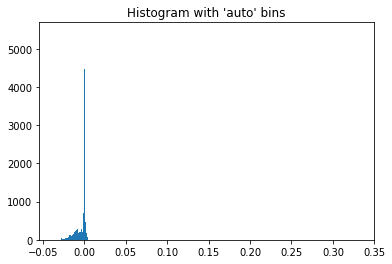

In [35]:
import matplotlib.pyplot as plt
#rng = np.random.RandomState(10)  # deterministic random data
#a = np.hstack(df["s_opt_sel"] - df["selectivity"])
plt.hist((df["s_opt_sel"] - df["selectivity"]).values, bins='auto') 
plt.title("Histogram with 'auto' bins")
plt.show()

Just to give us an idea of how the optimizer's statistics thought the selectivity would play out. It's close but rarely dead on. It's a bit optimistic in its assessment of how many records will be selected.

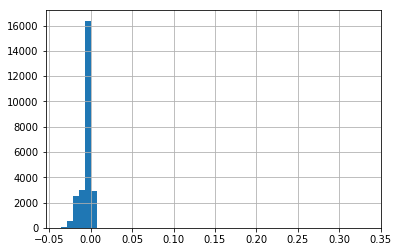

In [36]:
(df["s_opt_sel"] - df["selectivity"]).hist(bins=50)

In [37]:
import math

In [38]:
#ok, so what defines a good estimate vs a bad one? if it's not 0 +/- 1 std deviation?

df["s_opt_sel_cor"] = 0
std_dev = math.sqrt(stats_vals.variance)
df.loc[(df["s_opt_sel"] - df["selectivity"] < .001) & (df["s_opt_sel"] - df["selectivity"] > - .001), "s_opt_sel_cor"] = 1

In [39]:
df[df["s_opt_sel_cor"] == 0].shape

(11610, 83)

In [40]:
import matplotlib.pyplot as plt
def find_best(df1):
    df_out = pd.DataFrame()
    
    #group by the query and server, sort by selectivity, and take the top performing query
    for name, group in df1.sort_values("latency", ascending=True).groupby(["info_ec2","info_query_id","selectivity"], as_index=False):
        fastest = group.head(1)["latency"].iloc[0]
        closest = group[(group["latency"] <= fastest * 1.1)]
        df_out = pd.concat([df_out, group.head(1)])
        
    return df_out

In [41]:
fastest = df.sort_values("selectivity").groupby("selectivity").head(1)
fastest.shape

(302, 83)

In [42]:
#So, what's fair to categorize as "fastest" since each run will vary slightly?
#within 10% of the fastest time is reasonable
#find the fastest per server and query
df_best = find_best(df)

In [45]:
df_best.shape

(852, 83)

In [44]:
df[(df["info_query_id"] == 4) & (df["info_ec2"] == "c5d.4xlarge") & (df["selectivity"] > .02)]

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,selectivity,latency,info_ec2,info_query_id,s_rows,s_cost,s_workers,s_forced_p,s_p_mode,sc_o_q,sc_o_p,sc_o_s,sc_o_e,sc_o_d,sc_q,sc_p,sc_s,sc_e,sc_d,info_type,info_batch,s_p_cost,s_seq_page_cost,s_random_page_cost,s_cpu_tuple_cost,s_cpu_index_tuple_cost,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d,h_mem,h_cores,info_cpu,h_clk,h_l1d,h_l1i,h_l2,h_l3,h_numa,h_avx2,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,s_opt_sel,s_opt_sel_cor
1816,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.110,0.020002,2606.521,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1817,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.120,0.020002,2613.586,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1818,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.130,0.020002,2609.361,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1819,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.140,0.020002,2611.790,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1820,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.150,0.020002,2612.594,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1831,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.105,0.020002,2608.946,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1832,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.115,0.020002,2609.462,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1833,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.125,0.020002,2609.762,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1834,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.135,0.020002,2606.025,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0
1835,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.00,0,0,0,0,0.145,0.020002,2611.261,c5d.4xlarge,4,1051755,3075802.89,0,0,0,2,0,0,0,1,0,0,0,0,1,index,3-6c,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,1,0,0,1,1,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.017533,0


In [46]:
#Print how many sample are in the fastest category as opposed to the whole set

print("C5D")
for q in range(2,17):
    print (df_best[(df_best["info_ec2"] == "c5d.4xlarge") & (df_best["info_query_id"] == q)].shape, 
    df[(df["info_ec2"] == "c5d.4xlarge") & (df["info_query_id"] == q)].shape)
print("M5D")
for q in range(2,17):
    print (df_best[(df_best["info_ec2"] == "m5d.2xlarge") & (df_best["info_query_id"] == q)].shape, 
    df[(df["info_ec2"] == "m5d.2xlarge") & (df["info_query_id"] == q)].shape)
print("R5D")
for q in range(2,17):
    print (df_best[(df_best["info_ec2"] == "r5d.4xlarge") & (df_best["info_query_id"] == q)].shape, 
    df[(df["info_ec2"] == "r5d.4xlarge") & (df["info_query_id"] == q)].shape)

C5D
(3, 83) (54, 83)
(28, 83) (474, 83)
(13, 83) (435, 83)
(13, 83) (384, 83)
(37, 83) (520, 83)
(23, 83) (610, 83)
(19, 83) (470, 83)
(13, 83) (280, 83)
(12, 83) (276, 83)
(13, 83) (572, 83)
(14, 83) (548, 83)
(12, 83) (398, 83)
(29, 83) (777, 83)
(25, 83) (746, 83)
(15, 83) (644, 83)
M5D
(3, 83) (36, 83)
(28, 83) (351, 83)
(13, 83) (353, 83)
(13, 83) (311, 83)
(24, 83) (349, 83)
(23, 83) (488, 83)
(19, 83) (376, 83)
(13, 83) (266, 83)
(12, 83) (217, 83)
(13, 83) (494, 83)
(14, 83) (466, 83)
(14, 83) (369, 83)
(33, 83) (708, 83)
(29, 83) (695, 83)
(15, 83) (560, 83)
R5D
(3, 83) (36, 83)
(28, 83) (360, 83)
(13, 83) (435, 83)
(13, 83) (312, 83)
(28, 83) (386, 83)
(23, 83) (490, 83)
(19, 83) (380, 83)
(13, 83) (280, 83)
(12, 83) (222, 83)
(13, 83) (494, 83)
(14, 83) (470, 83)
(14, 83) (365, 83)
(30, 83) (710, 83)
(25, 83) (680, 83)
(15, 83) (560, 83)


Although we never use this (we do a regression as opposed to classification), it's good to keep in case we want to go that way.

In [48]:
df["y_ideal"] = 0
df.loc[df.index.isin(df_best.index), "y_ideal"] = 1

In [50]:
df[df["y_ideal"] == 0].shape

(19463, 84)

In [51]:
df[df["y_ideal"] == 1].shape

(5866, 84)

Visualize how the fast vs slow performers compare. They should cluster, because indexes should perform similarly, and so should scans.

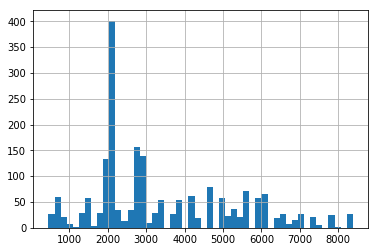

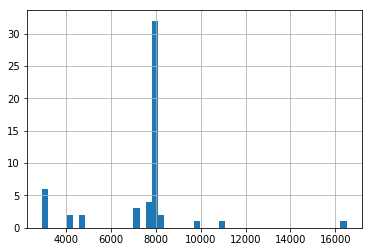

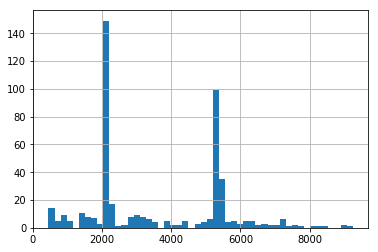

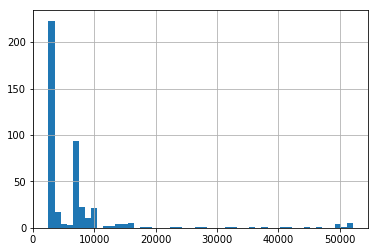

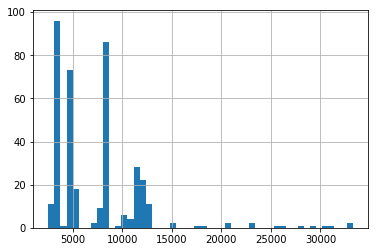

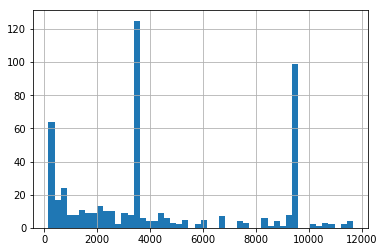

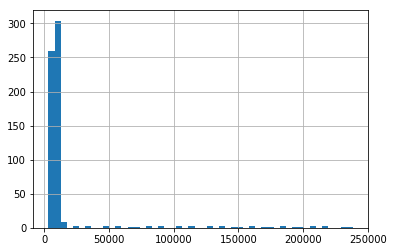

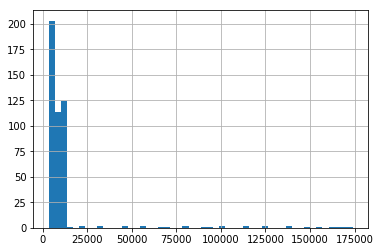

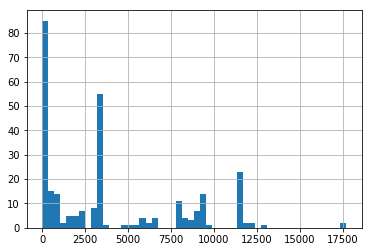

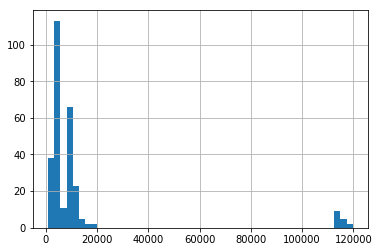

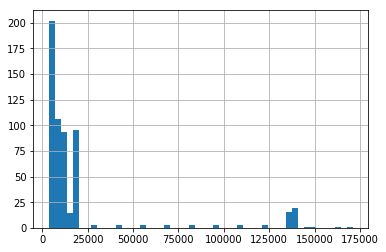

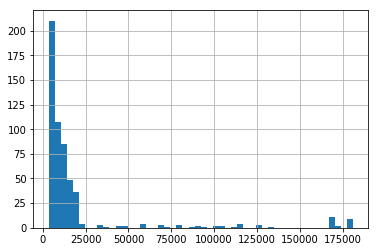

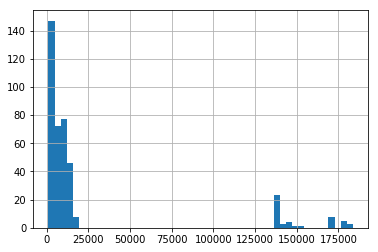

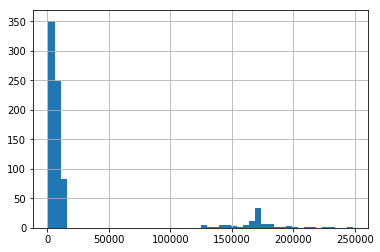

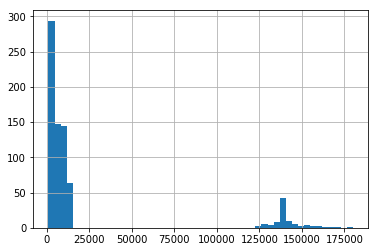

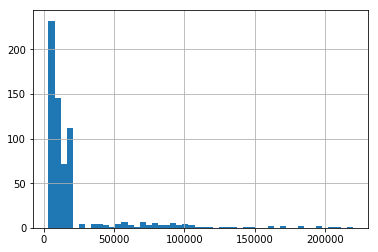

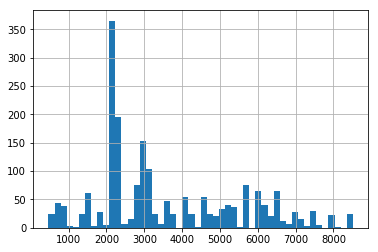

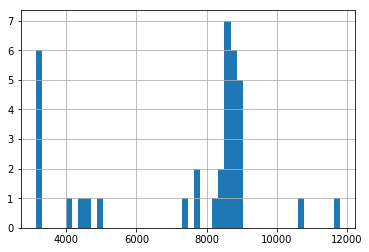

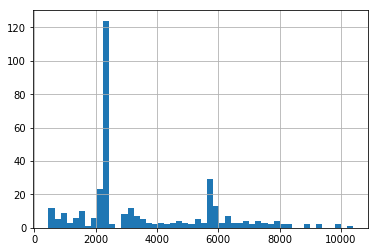

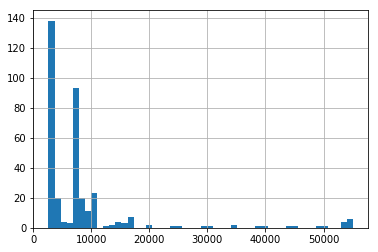

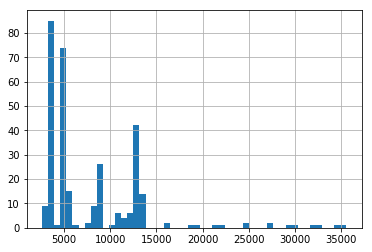

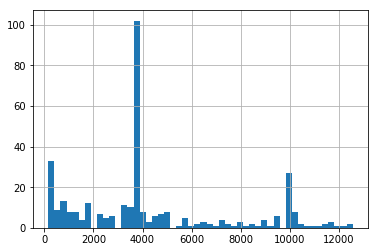

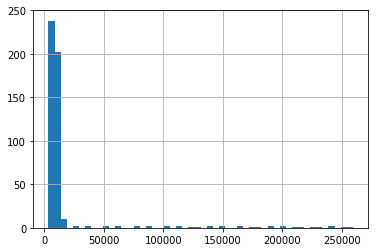

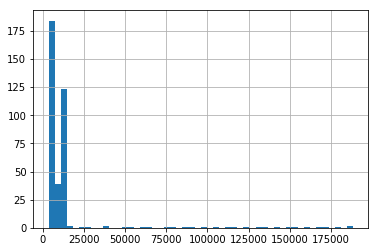

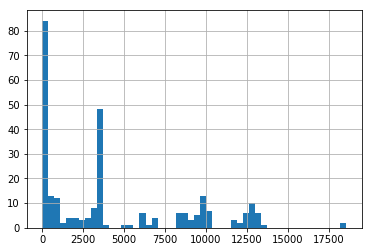

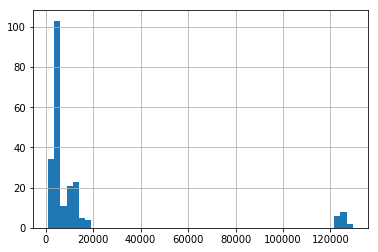

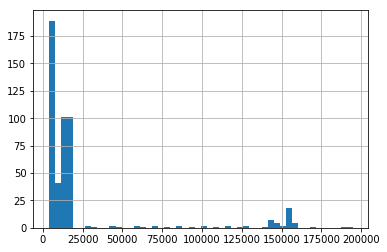

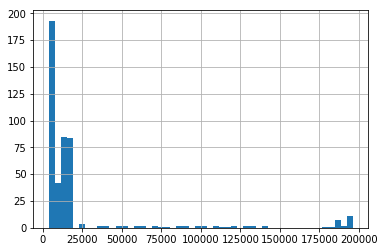

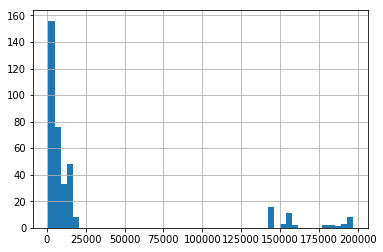

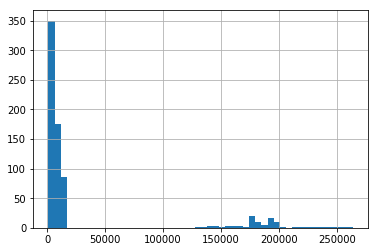

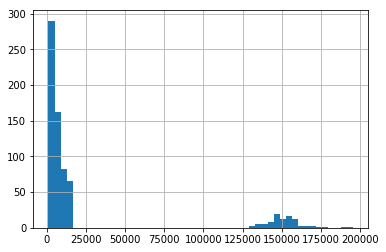

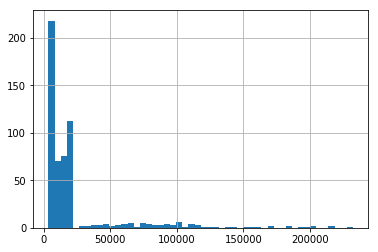

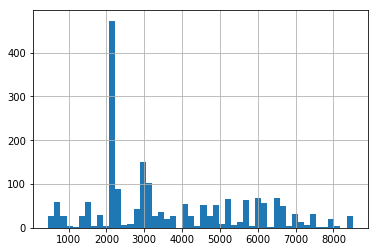

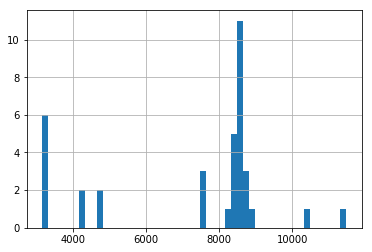

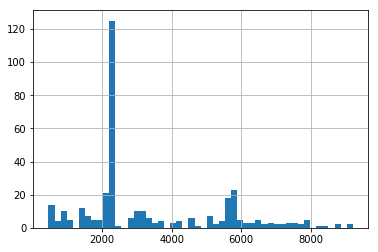

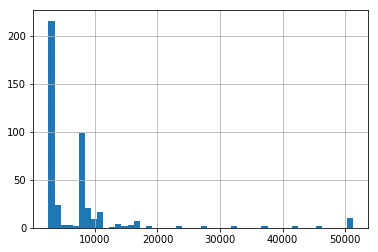

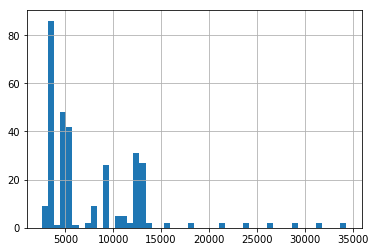

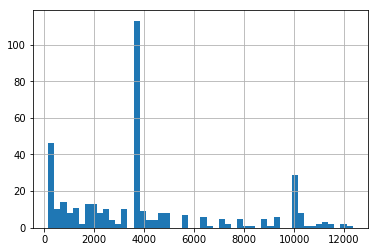

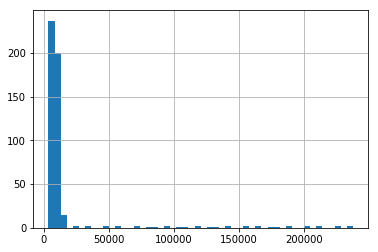

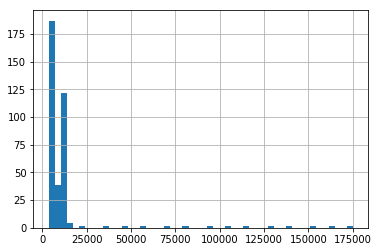

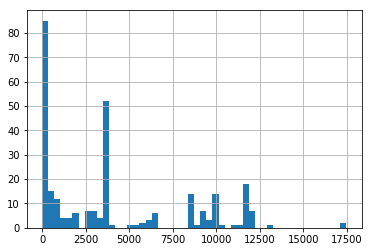

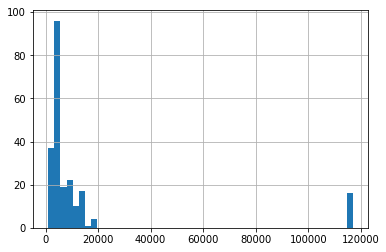

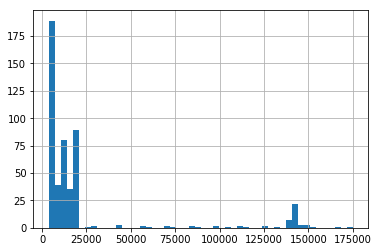

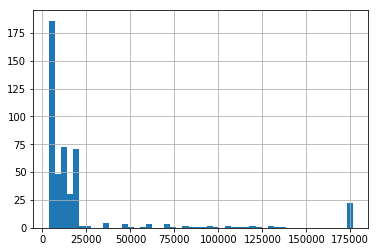

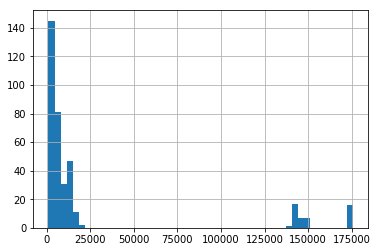

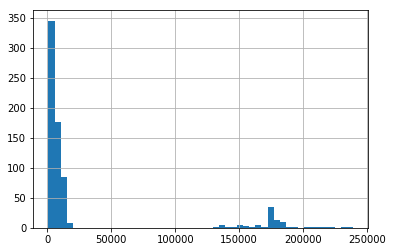

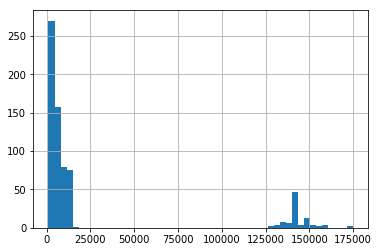

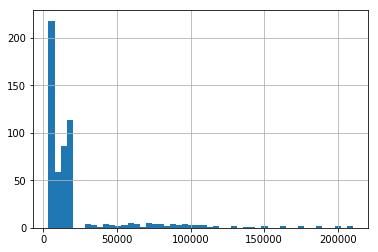

In [52]:
for name, group in df.sort_values("latency", ascending=True).groupby(["info_ec2","info_query_id"], as_index=False):
    stats_val = stats.describe(group["latency"])
    group["latency"].hist(bins=50)
    plt.show()

Most of the following categorical features are re-encoded as one-hot encodings as describe below. Think of them as intermediate columns

| Field  | Description  |Type|
|---|---|---|
|s_workers|The number of workers used|Continuous|
|selectivity  |  measured selectivity |Continuous|
|idx_q|Index present on l_quantity|Categorical|
|idx_e|Index present on l_extendedprice|Categorical|
|idx_p|Index present on l_partkey|Categorical|
|idx_s|Index present on l_suppkey|Categorical|
|idx_d|Index present on l_discount|Categorical|
|i_q|Index used on l_quantity|Categorical|
|i_p|Index used on l_partkey|Categorical|
|i_s|Index used on l_suppkey|Categorical|
|i_e|Index used on l_extendedprice|Categorical|
|i_d|Index used on l_discount|Categorical|
|i_o_q|The order l_quantity was applied|Continuous|
|i_o_p|The order l_partkey index was applied|Continuous|
|i_o_s|The order l_suppkey index was applied|Continuous|
|i_o_e|The order l_extendedprice index was applied|Continuous|
|i_o_d|The order l_discount index was applied|Continuous|
|b_i_q|Bitmap Index used on l_quantity|Categorical|
|b_i_p|Bitmap Index used on l_partkey|Categorical|
|b_i_s|Bitmap Index used on l_suppkey|Categorical|
|b_i_e|Bitmap Index used on l_extendedprice|Categorical|
|b_i_d|Bitmap Index used on l_discount|Categorical|
|sc_q|Scan performed on l_quantity|Categorical|
|sc_p|Scan performed on l_partkey|Categorical|
|sc_s|Scan performed on l_suppkey|Categorical|
|sc_e|Scan performed on l_extendedprice|Categorical|
|sc_d|Scan performed on l_discount|Categorical|
|sc_o_q|Order Scan performed on l_quantity|Categorical|
|sc_o_p|Order Scan performed on l_partkey|Categorical|
|sc_o_s|Order Scan performed on l_suppkey|Categorical|
|sc_o_e|Order Scan performed on l_extendedprice|Categorical|
|sc_o_d|Order Scan performed on l_discount|Categorical|
|v_i_q|The value (<=) that was index scanned on l_quantity|Continuous|
|v_i_p|The value (<=) that was index scanned on l_partkey|Continuous|
|v_i_s|The value (<=) that was index scanned on l_suppkey|Continuous|
|v_i_e|The value (<=) that was index scanned on l_extendedprice|Continuous|
|v_i_d|The value (<=) that was index scanned on l_discount|Continuous|
|v_f_q|The value (<=) that was filter scanned on l_quantity|Continuous|
|v_f_p|The value (<=) that was filter scanned on l_partkey|Continuous|
|v_f_s|The value (<=) that was filter scanned on l_suppkey|Continuous|
|v_f_e|The value (<=) that was filter scanned on l_extendedprice|Continuous|
|v_f_d|The value (<=) that was filter scanned on l_discount|Continuous|

Labeled Fields

| Field  | Description  |Type|
|---|---|---|
|y_latency  |  measured latency |Numerical Label|
|y_ideal|The ideal option?|Categorical Label|

In [54]:
#one more thing (I changed my mind to this later)... encode the v_i_e/v_f_e into predicates, like this: p_e (0/1), 
#  p_e_op ("E","LT","GTE","GT","LTE"), p_e_v (the numerical value), p_e_path ("filter","index","bitmap"), p_e_o (predicate order)
df["p_e"] = 0
df["p_e_op"] = ""
df["p_e_v"] = 0
df["p_e_path"] = ""
df["p_q"] = 0
df["p_q_op"] = ""
df["p_q_v"] = 0
df["p_q_path"] = ""
df["p_s"] = 0
df["p_s_op"] = ""
df["p_s_v"] = 0
df["p_s_path"] = ""
df["p_p"] = 0
df["p_p_op"] = ""
df["p_p_v"] = 0
df["p_p_path"] = ""
df["p_d"] = 0
df["p_d_op"] = ""
df["p_d_v"] = 0
df["p_d_path"] = ""
df["p_e_o"] = 0
df["p_d_o"] = 0
df["p_s_o"] = 0
df["p_p_o"] = 0
df["p_q_o"] = 0


df.loc[df["info_query_id"] == 1, "p_p_op"] = "LT"
#3's, 4's, 5's
#df.loc[df["info_batch"].str.startswith("2-"), "p_e_op"] = "LT"
#This is purely informational (for human readability)
df.loc[df["info_query_id"] == 2, "p_q_op"] = "LT"
df.loc[df["info_query_id"] == 3, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 4, "p_q_op"] = "LT"
df.loc[df["info_query_id"] == 4, "p_d_op"] = "LT"
df.loc[df["info_query_id"] == 5, "p_q_op"] = "LT"
df.loc[df["info_query_id"] == 5, "p_d_op"] = "LT"
df.loc[df["info_query_id"] == 6, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 7, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 7, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 8, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 8, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 9, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 9, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 10, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 10, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 11, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 11, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 11, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 12, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 12, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 12, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 13, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 13, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 13, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 14, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 14, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 14, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 15, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 15, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 15, "p_p_op"] = "LT"
df.loc[df["info_query_id"] == 16, "p_e_op"] = "GT"
df.loc[df["info_query_id"] == 16, "p_s_op"] = "LT"
df.loc[df["info_query_id"] == 16, "p_p_op"] = "LT"

#for extended price
df.loc[df["v_i_e"] != 0, "p_e"] = 1
df.loc[df["i_o_e"] != 0, "p_e_o"] = df[df["i_o_e"] != 0]["i_o_e"]
df.loc[df["v_i_e"] != 0, "p_e_v"] = df[df["v_i_e"] != 0]["v_i_e"]
df.loc[df["v_i_e"] != 0, "p_e_path"] = "index"
df.loc[df["v_f_e"] != 0, "p_e"] = 1
df.loc[df["sc_o_e"] != 0, "p_e_o"] = df[df["sc_o_e"] != 0]["sc_o_e"]
df.loc[df["v_f_e"] != 0, "p_e_v"] = df[df["v_f_e"] != 0]["v_f_e"]
df.loc[df["v_f_e"] != 0, "p_e_path"] = "filter"
df.loc[df["b_i_e"] != 0, "p_e"] = 1
df.loc[df["b_i_e"] != 0, "p_e_v"] = df[df["b_i_e"] != 0]["b_i_e"]
df.loc[df["b_i_e"] != 0, "p_e_path"] = "bitmap"

#for suppkey
df.loc[df["v_i_s"] != 0, "p_s"] = 1
df.loc[df["i_o_s"] != 0, "p_s_o"] = df[df["i_o_s"] != 0]["i_o_s"]
df.loc[df["v_i_s"] != 0, "p_s_v"] = df[df["v_i_s"] != 0]["v_i_s"]
df.loc[df["v_i_s"] != 0, "p_s_path"] = "index"
df.loc[df["v_f_s"] != 0, "p_s"] = 1
df.loc[df["sc_o_s"] != 0, "p_s_o"] = df[df["sc_o_s"] != 0]["sc_o_s"]
df.loc[df["v_f_s"] != 0, "p_s_v"] = df[df["v_f_s"] != 0]["v_f_s"]
df.loc[df["v_f_s"] != 0, "p_s_path"] = "filter"
df.loc[df["b_i_s"] != 0, "p_s"] = 1
df.loc[df["b_i_s"] != 0, "p_s_v"] = df[df["b_i_s"] != 0]["b_i_s"]
df.loc[df["b_i_s"] != 0, "p_s_path"] = "bitmap"

#for discount
df.loc[df["v_i_d"] != 0, "p_d"] = 1
df.loc[df["i_o_d"] != 0, "p_d_o"] = df[df["i_o_d"] != 0]["i_o_d"]
df.loc[df["v_i_d"] != 0, "p_d_v"] = df[df["v_i_d"] != 0]["v_i_d"]
df.loc[df["v_i_d"] != 0, "p_d_path"] = "index"
df.loc[df["v_f_d"] != 0, "p_d"] = 1
df.loc[df["sc_o_d"] != 0, "p_d_o"] = df[df["sc_o_d"] != 0]["sc_o_d"]
df.loc[df["v_f_d"] != 0, "p_d_v"] = df[df["v_f_d"] != 0]["v_f_d"]
df.loc[df["v_f_d"] != 0, "p_d_path"] = "filter"
df.loc[df["b_i_d"] != 0, "p_d"] = 1
df.loc[df["b_i_d"] != 0, "p_d_v"] = df[df["b_i_d"] != 0]["b_i_d"]
df.loc[df["b_i_d"] != 0, "p_d_path"] = "bitmap"

#for partkey
df.loc[df["v_i_p"] != 0, "p_p"] = 1
df.loc[df["i_o_p"] != 0, "p_p_o"] = df[df["i_o_p"] != 0]["i_o_p"]
df.loc[df["v_i_p"] != 0, "p_p_v"] = df[df["v_i_p"] != 0]["v_i_p"]
df.loc[df["v_i_p"] != 0, "p_p_path"] = "index"
df.loc[df["v_f_p"] != 0, "p_p"] = 1
df.loc[df["sc_o_p"] != 0, "p_p_o"] = df[df["sc_o_p"] != 0]["sc_o_p"]
df.loc[df["v_f_p"] != 0, "p_p_v"] = df[df["v_f_p"] != 0]["v_f_p"]
df.loc[df["v_f_p"] != 0, "p_p_path"] = "filter"
df.loc[df["b_i_p"] != 0, "p_p"] = 1
df.loc[df["b_i_p"] != 0, "p_p_v"] = df[df["b_i_p"] != 0]["b_i_p"]
df.loc[df["b_i_p"] != 0, "p_p_path"] = "bitmap"

#for quantity
df.loc[df["v_i_q"] != 0, "p_q"] = 1
df.loc[df["i_o_q"] != 0, "p_q_o"] = df[df["i_o_q"] != 0]["i_o_q"]
df.loc[df["v_i_q"] != 0, "p_q_v"] = df[df["v_i_q"] != 0]["v_i_q"]
df.loc[df["v_i_q"] != 0, "p_q_path"] = "index"
df.loc[df["v_f_q"] != 0, "p_q"] = 1
df.loc[df["sc_o_q"] != 0, "p_q_o"] = df[df["sc_o_q"] != 0]["sc_o_q"]
df.loc[df["v_f_q"] != 0, "p_q_v"] = df[df["v_f_q"] != 0]["v_f_q"]
df.loc[df["v_f_q"] != 0, "p_q_path"] = "filter"
df.loc[df["b_i_q"] != 0, "p_q"] = 1
df.loc[df["b_i_q"] != 0, "p_q_v"] = df[df["b_i_q"] != 0]["b_i_q"]
df.loc[df["b_i_q"] != 0, "p_q_path"] = "bitmap"

In [55]:
df.head()

,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,selectivity,latency,info_ec2,info_query_id,s_rows,s_cost,s_workers,s_forced_p,s_p_mode,sc_o_q,sc_o_p,sc_o_s,sc_o_e,sc_o_d,sc_q,sc_p,sc_s,sc_e,sc_d,info_type,info_batch,s_p_cost,s_seq_page_cost,s_random_page_cost,s_cpu_tuple_cost,s_cpu_index_tuple_cost,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d,h_mem,h_cores,info_cpu,h_clk,h_l1d,h_l1i,h_l2,h_l3,h_numa,h_avx2,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,s_opt_sel,s_opt_sel_cor,y_ideal,p_e,p_e_op,p_e_v,p_e_path,p_q,p_q_op,p_q_v,p_q_path,p_s,p_s_op,p_s_v,p_s_path,p_p,p_p_op,p_p_v,p_p_path,p_d,p_d_op,p_d_v,p_d_path,p_e_o,p_d_o,p_s_o,p_p_o,p_q_o
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0.020002,16506.344,c5d.4xlarge,2,1191828,1967851.83,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.019868,1,0,0,,0,,1,LT,2,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0.039981,8238.213,c5d.4xlarge,2,2433650,1970956.39,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.040570,1,0,0,,0,,1,LT,3,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0.060007,8126.125,c5d.4xlarge,2,3563488,1973780.98,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.059405,1,0,0,,0,,1,LT,4,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0.020002,7898.164,c5d.4xlarge,2,1191828,1967851.83,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.019868,1,0,0,,0,,1,LT,2,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0.039981,8018.367,c5d.4xlarge,2,2433650,1970956.39,0,0,0,1,0,0,0,0,1,0,0,0,0,scan,3-1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0.040570,1,0,0,,0,,1,LT,3,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1


In [56]:
df.columns.values

array(['i_q', 'i_p', 'i_s', 'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s',
       'i_o_e', 'i_o_d', 'b_i_q', 'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d',
       'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e', 'v_i_d', 'v_f_q', 'v_f_p',
       'v_f_s', 'v_f_e', 'v_f_d', 'selectivity', 'latency', 'info_ec2',
       'info_query_id', 's_rows', 's_cost', 's_workers', 's_forced_p',
       's_p_mode', 'sc_o_q', 'sc_o_p', 'sc_o_s', 'sc_o_e', 'sc_o_d',
       'sc_q', 'sc_p', 'sc_s', 'sc_e', 'sc_d', 'info_type', 'info_batch',
       's_p_cost', 's_seq_page_cost', 's_random_page_cost',
       's_cpu_tuple_cost', 's_cpu_index_tuple_cost',
       's_cpu_operator_cost', 's_min_parallel_table_scan_size',
       's_min_parallel_index_scan_size', 's_parallel_tuple_cost',
       's_effective_cache_size', 'idx_q', 'idx_e', 'idx_p', 'idx_s',
       'idx_d', 'h_mem', 'h_cores', 'info_cpu', 'h_clk', 'h_l1d', 'h_l1i',
       'h_l2', 'h_l3', 'h_numa', 'h_avx2', 'h_avx512bw', 'h_avx512vl',
       'h_avx512cd', 'h_avx512dq', 'h_bogomips'

In [57]:
#one final column renaming
df2 = df[['selectivity', 'latency', 'y_ideal', 'info_ec2',
       'info_query_id', 'info_type', 'info_batch', 's_rows', 's_cost', 's_workers', 's_forced_p','s_p_mode',  
       's_opt_sel', 's_opt_sel_cor', 's_p_cost', 's_seq_page_cost', 's_random_page_cost',
       's_cpu_tuple_cost', 's_cpu_index_tuple_cost',
       's_cpu_operator_cost', 's_min_parallel_table_scan_size',
       's_min_parallel_index_scan_size', 's_parallel_tuple_cost',
       's_effective_cache_size', 'idx_q', 'idx_e', 'idx_p', 'idx_s',
       'idx_d', 'h_mem', 'h_cores', 'info_cpu', 'h_clk', 'h_l1d', 'h_l1i',
       'h_l2', 'h_l3', 'h_numa', 'h_avx2', 'h_avx512bw', 'h_avx512vl',
       'h_avx512cd', 'h_avx512dq', 'h_bogomips', 'h_ss',
       'h_3dnowprefetch', 'h_erms', 'h_bmi2', 'h_invpcid', 'p_e', 'p_e_op', 'p_e_v', 'p_e_path',
       'p_q', 'p_q_op', 'p_q_v', 'p_q_path', 'p_s', 'p_s_op', 'p_s_v',
       'p_s_path', 'p_p', 'p_p_op', 'p_p_v', 'p_p_path', 'p_d', 'p_d_op',
       'p_d_v', 'p_d_path','p_e_o', 'p_s_o', 'p_d_o', 'p_p_o',
       'p_q_o']]

In [58]:
df2.head()

,selectivity,latency,y_ideal,info_ec2,info_query_id,info_type,info_batch,s_rows,s_cost,s_workers,s_forced_p,s_p_mode,s_opt_sel,s_opt_sel_cor,s_p_cost,s_seq_page_cost,s_random_page_cost,s_cpu_tuple_cost,s_cpu_index_tuple_cost,s_cpu_operator_cost,s_min_parallel_table_scan_size,s_min_parallel_index_scan_size,s_parallel_tuple_cost,s_effective_cache_size,idx_q,idx_e,idx_p,idx_s,idx_d,h_mem,h_cores,info_cpu,h_clk,h_l1d,h_l1i,h_l2,h_l3,h_numa,h_avx2,h_avx512bw,h_avx512vl,h_avx512cd,h_avx512dq,h_bogomips,h_ss,h_3dnowprefetch,h_erms,h_bmi2,h_invpcid,p_e,p_e_op,p_e_v,p_e_path,p_q,p_q_op,p_q_v,p_q_path,p_s,p_s_op,p_s_v,p_s_path,p_p,p_p_op,p_p_v,p_p_path,p_d,p_d_op,p_d_v,p_d_path,p_e_o,p_s_o,p_d_o,p_p_o,p_q_o
0,0.020002,16506.344,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,0,0,0.019868,1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0,,0,,1,LT,2,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
1,0.039981,8238.213,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,0,0,0.040570,1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0,,0,,1,LT,3,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
2,0.060007,8126.125,0,c5d.4xlarge,2,scan,3-1,3563488,1973780.98,0,0,0,0.059405,1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0,,0,,1,LT,4,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
3,0.020002,7898.164,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,0,0,0.019868,1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0,,0,,1,LT,2,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1
4,0.039981,8018.367,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,0,0,0.040570,1,1000000,1,4,0.01,0.005,0.0025,8,0.5,0.1,4,0,0,0,0,0,30,16,Intel(R) Xeon(R) Platinum 8124M,3405.776,32,32,1024,25344,1,1,1,1,1,1,6000.0,1,1,1,1,1,0,,0,,1,LT,3,filter,0,,0,,0,,0,,0,,0.0,,0,0,0,0,1


In [59]:
df2.shape

(25329, 74)

The set is now clean and combined in a human-readable form. 

In [60]:
df2.to_csv('data/performance_data.csv', index=False)

Next comes the one-hot encodings re-encoded using the following ("p_" means "Predicate" part of the query, then next character indicates the column ("e"=extended price,"p"=partkey,"s"=suppkey,"d"=discount,"q"=quantity)

| Field  | Description  |Column|Type|
|---|---|---|---|
|p_e|in the predicate?|extended price|Categorical|
|p_e_op|Predicate operation ("LT", "GT", "LTE", "GTE")|extended price|Information ONLY not used|
|p_e_op_eq|Predicate operation = used|extended price|Categorical|
|p_e_op_lt|Predicate operation < used|extended price|Categorical|
|p_e_op_gt|Predicate operation > used|extended price|Categorical|
|p_e_op_lte|Predicate operation <= used|extended price|Categorical|
|p_e_op_gte|Predicate operation >= used|extended price|Categorical|
|p_e_v|Predicate value|extended price|Continuous|
|p_e_path|"index","filter","bitmap"|extended price|Information ONLY not used|
|p_e_path_index|Was index used?|extended price|Categorical|
|p_e_path_filter|Was scan used?|extended price|Categorical|
|p_e_path_bitmap|Was bitmap used?|extended price|Categorical|
|p_e_o|Order this column was applied in the predicate|extended price|Categorical|
|p_d|in the predicate?|discount|Categorical|
|p_d_op|Predicate operation ("LT", "GT", "LTE", "GTE")|discount|Information ONLY not used|
|p_d_op_eq|Predicate operation = used|discount|Categorical|
|p_d_op_lt|Predicate operation < used|discount|Categorical|
|p_d_op_gt|Predicate operation > used|discount|Categorical|
|p_d_op_lte|Predicate operation <= used|discount|Categorical|
|p_d_op_gte|Predicate operation >= used|discount|Categorical|
|p_d_v|Predicate value|discount|Continuous|
|p_d_path|"index","filter","bitmap"|discount|Information ONLY not used|
|p_d_path_index|Was index used?|discount|Categorical|
|p_d_path_filter|Was scan used?|discount|Categorical|
|p_d_path_bitmap|Was bitmap used?|discount|Categorical|
|p_d_o|Order this column was applied in the predicate|discount|Categorical|
|p_s|in the predicate?|suppkey|Categorical|
|p_s_op|Predicate operation ("LT", "GT", "LTE", "GTE")|suppkey|Information ONLY not used|
|p_s_op_eq|Predicate operation = used|suppkey|Categorical|
|p_s_op_lt|Predicate operation < used|suppkey|Categorical|
|p_s_op_gt|Predicate operation > used|suppkey|Categorical|
|p_s_op_lte|Predicate operation <= used|suppkey|Categorical|
|p_s_op_gte|Predicate operation >= used|suppkey|Categorical|
|p_s_v|Predicate value|suppkey|Continuous|
|p_s_path|"index","filter","bitmap"|suppkey|Information ONLY not used|
|p_s_path_index|Was index used?|suppkey|Categorical|
|p_s_path_filter|Was scan used?|suppkey|Categorical|
|p_s_path_bitmap|Was bitmap used?|suppkey|Categorical|
|p_s_o|Order this column was applied in the predicate|suppkey|Categorical|
|p_p|in the predicate?|partkey|Categorical|
|p_p_op|Predicate operation ("LT", "GT", "LTE", "GTE")|partkey|Information ONLY not used|
|p_p_op_eq|Predicate operation = used|partkey|Categorical|
|p_p_op_lt|Predicate operation < used|partkey|Categorical|
|p_p_op_gt|Predicate operation > used|partkey|Categorical|
|p_p_op_lte|Predicate operation <= used|partkey|Categorical|
|p_p_op_gte|Predicate operation >= used|partkey|Categorical|
|p_p_v|Predicate value|partkey|Continuous|
|p_p_path|"index","filter","bitmap"|partkey|Information ONLY not used|
|p_p_path_index|Was index used?|partkey|Categorical|
|p_p_path_filter|Was scan used?|partkey|Categorical|
|p_p_path_bitmap|Was bitmap used?|partkey|Categorical|
|p_p_o|Order this column was applied in the predicate|partkey|Categorical|
|p_q|in the predicate?|quantity|Categorical|
|p_q_op|Predicate operation ("LT", "GT", "LTE", "GTE")|quantity|Information ONLY not used|
|p_q_op_eq|Predicate operation = used|quantity|Categorical|
|p_q_op_lt|Predicate operation < used|quantity|Categorical|
|p_q_op_gt|Predicate operation > used|quantity|Categorical|
|p_q_op_lte|Predicate operation <= used|quantity|Categorical|
|p_q_op_gte|Predicate operation >= used|quantity|Categorical|
|p_q_v|Predicate value|quantity|Continuous|
|p_q_path|"index","filter","bitmap"|quantity|Information ONLY not used|
|p_q_path_index|Was index used?|quantity|Categorical|
|p_q_path_filter|Was scan used?|quantity|Categorical|
|p_q_path_bitmap|Was bitmap used?|quantity|Categorical|
|p_q_o|Order this column was applied in the predicate|quantity|Categorical|

In [63]:
#set all of these categorical values to 0
df2["p_q_path_index"] = 0
df2["p_q_path_filter"] = 0
df2["p_q_path_bitmap"] = 0
df2["p_s_path_index"] = 0
df2["p_s_path_filter"] = 0
df2["p_s_path_bitmap"] = 0
df2["p_d_path_index"] = 0
df2["p_d_path_filter"] = 0
df2["p_d_path_bitmap"] = 0
df2["p_p_path_index"] = 0
df2["p_p_path_filter"] = 0
df2["p_p_path_bitmap"] = 0
df2["p_e_path_index"] = 0
df2["p_e_path_filter"] = 0
df2["p_e_path_bitmap"] = 0

#set only the ones affected to 1
def path_to_categorical(df, index):
    path = "p_" + index + "_path"
    df.loc[df[path] == 'index', path + "_index"] = 1
    df.loc[df[path] == 'filter',  path + "_filter"] = 1
    df.loc[df[path] == 'bitmap',  path + "_bitmap"] = 1

path_to_categorical(df2, "e")
path_to_categorical(df2, "d")
path_to_categorical(df2, "q")
path_to_categorical(df2, "p")
path_to_categorical(df2, "s")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [64]:
#seed these all to zero
df2.loc[df2["info_query_id"] == 16, "p_p_op"] = "LT"
df2["p_p_op_eq"] = 0
df2["p_p_op_lt"] = 0
df2["p_p_op_gt"] = 0
df2["p_p_op_lte"] = 0
df2["p_p_op_gte"] = 0

df2["p_q_op_eq"] = 0
df2["p_q_op_lt"] = 0
df2["p_q_op_gt"] = 0
df2["p_q_op_lte"] = 0
df2["p_q_op_gte"] = 0

df2["p_e_op_eq"] = 0
df2["p_e_op_lt"] = 0
df2["p_e_op_gt"] = 0
df2["p_e_op_lte"] = 0
df2["p_e_op_gte"] = 0

df2["p_s_op_eq"] = 0
df2["p_s_op_lt"] = 0
df2["p_s_op_gt"] = 0
df2["p_s_op_lte"] = 0
df2["p_s_op_gte"] = 0

df2["p_d_op_eq"] = 0
df2["p_d_op_lt"] = 0
df2["p_d_op_gt"] = 0
df2["p_d_op_lte"] = 0
df2["p_d_op_gte"] = 0

#Set the one-hot values
def op_to_categorical(df, index):
    op = "p_" + index + "_op"
    df.loc[df[op] == 'LT', op + "_lt"] = 1
    df.loc[df[op] == 'LTE', op + "_lte"] = 1
    df.loc[df[op] == 'GT', op + "_gt"] = 1
    df.loc[df[op] == 'GTE', op + "_gte"] = 1
    df.loc[df[op] == 'EQ', op + "_eq"] = 1

op_to_categorical(df2, "e")
op_to_categorical(df2, "d")
op_to_categorical(df2, "p")
op_to_categorical(df2, "s")
op_to_categorical(df2, "q")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [65]:
df2.shape

(25329, 114)

In [66]:
df2[df2["y_ideal"] == 1].shape

(5866, 114)

In [68]:
df2.to_csv('data/performance_data_one_hot.csv', index=False)

Finally, we'll balance the set by adding an equal number of ideal and non-ideal data elements. We'll save that as a separate file in case we need it.

In [69]:
def generate_for_query(df, query, factor):
    data = df[(df["y_ideal"]==1) & (df["info_query_id"]==query)]
    mean = data.describe()["latency"].mean()
    std = data.describe()["latency"].std()
    
    result = data.copy()
    
    for i in range(0, factor):
        new_data = data.copy()
        
        new_latencies = []
        for x in range(0, new_data.shape[0]):
            new_latencies.append(rnd.gauss(mean, std))
        
        new_data["latency"] = pd.DataFrame(new_latencies)
        result = pd.concat([new_data, result], axis=0)
    
    return result

In [70]:
#generate more good samples
import random as rnd
df2_aug = df2.copy()
for i in range(6,17):
    test_df = generate_for_query(df2, i, 4) #factor 4 since the data is imbalanced
    df2_aug = pd.concat([test_df, df2_aug], axis=0)

In [71]:
df2_aug.shape

(42304, 114)

In [72]:
df2_aug[df2_aug["y_ideal"] == 1].shape

(22841, 114)

In [73]:
df2_aug[df2_aug["y_ideal"] == 0].shape

(19463, 114)

In [74]:
df2_aug.to_csv('data/performance_data_one_hot_augmented.csv', index=False)